# QSVC (into the details)
<a target="_blank" href="https://colab.research.google.com/github/Torben2907/qml-supervised/blob/master/tutorials/03_quantum_kernel_learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

$\blacktriangleright$ This is the **3rd** part of a notebook series demonstrating the functionality of the <code>QMLab</code>-Package. 

[Click here to get to Part 1](./classical_learning.ipynb) &nbsp; or &nbsp; 
[Part 3](./training_quantum_kernels.ipynb).

Now let's look into the details of what happened in [Part 2](02_quantum_advantage.ipynb).

The entire progress of computing the gram matrix can be outsourced to a quantum computer. 

The rest of the support vector algorithm stays exactly the same - resulting in a hybrid algorithm.

It's called a **Q**uantum **S**upport **V**ector **C**lassifier - <code>QSVC</code> for short.

First we needed an **data embedding** that maps our data vectors into a Hilbert space $\mathcal{H}$, the space where state vectors $\Ket{\psi}$ exist.

An data embedding is a feature map of the form  
$$ 
\mathbf{x} \in \mathbb{R}^d \longrightarrow \Ket{\psi(\mathbf{x})} \in \mathcal{H} \tag{1}
$$
where we obtain the state vector by applying a parameterized unitary to the ground state of a quantum circuit, i.e. 
$$
\mathcal{U}(\mathbf{x}) \Ket{0} = \Ket{\psi(\mathbf{x})}.\tag{2} $$

We can obtain two different quantum states by parameterizing them with different data vectors and measure their fidelity:
$$
\hat{K}_{ij} = \left| \Braket{\psi(\boldsymbol{x}_j) | \psi(\boldsymbol{x}_i)}\right|^2 \quad i, j \in \{1, \ldots, n\}, 
\tag{3}
$$
where $n$ is number of training examples.

We prepare the state 
$$
\mathcal{U}^\dagger(\boldsymbol{x}_j) \; \mathcal{U}(\boldsymbol{x}_i) \Ket{0} 
$$

and measuring the probability of measuring a bitstring only consisting of zeros, i.e. 
$$
\hat{K}_{ij} = P(measure\Ket{0})
= \left| \Braket{0 | \mathcal{U}^\dagger(\mathbf{x}_j) \, \mathcal{U}(\boldsymbol{x}_i) | 0 } \right|^2 = \left| \Braket{\psi(\mathbf{x}_j) | \psi(\mathbf{x}_i)}\right|^2 
$$

For more details we refer to the section "Inversion and SWAP test" of the thesis.

In [1]:
import numpy as np
from sklearn import metrics
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qmlab.kernel import FidelityQuantumKernel
from qmlab.preprocessing import (
    parse_biomed_data_to_ndarray,
    parse_biomed_data_to_df,
    scale_to_specified_interval,
)
from qmlab.plotting import (
    set_plot_style,
    plot_kernel_heatmap,
)
import plotly.express as px

random_state = 12345
np.random.seed(random_state)
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
set_plot_style("dark_background")

## Data & Preprocessing

Let's start by loading the **HABERMAN**-dataset, scaling it to $[-\pi/2, \pi/2]$ and 
for the sake of this tutorial splitting it into two disjoint sets.

The first one will be used to fit the quantum-based model, the latter will be used to see how well 
it can generalize to unseen data. 

Just like in the main text these are the training and testing set respectively.

In [2]:
X, y, _ = parse_biomed_data_to_ndarray("haberman_new")
X = scale_to_specified_interval(X, interval=(-np.pi / 2, np.pi / 2))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Let's visualize the **HABERMAN** data by using <code>Plotly</code>:

In [3]:
df = parse_biomed_data_to_df("haberman_new")
fig = px.scatter_3d(
    df,
    x="V2",
    y="V3",
    z="V4",
    color="V1",
    size_max=18,
    template="plotly_dark",
    color_discrete_map="seaborn"
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Quantum Circuits


Now it's time to take a closer look into the quantum circuits that are used to embed our data.

Here's how the quantum circuit for the first sample $\bm{x}^{(1)}$ with <code>AngleEmbedding</code> looks like:

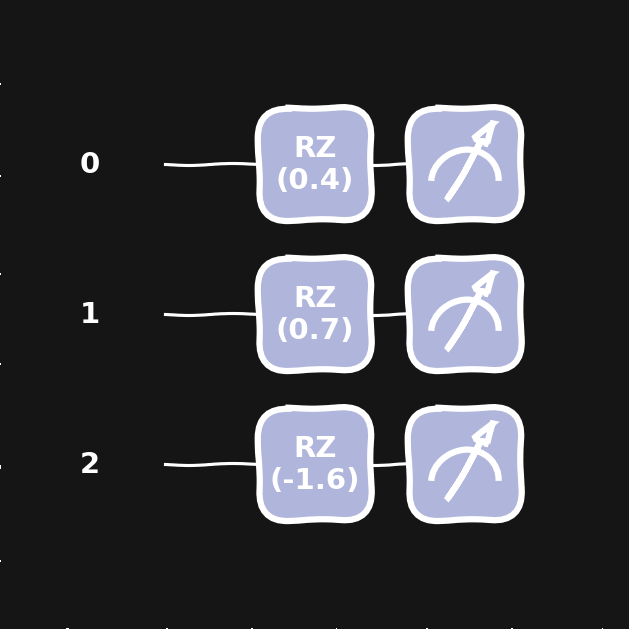

In [4]:
from sklearn.svm import SVC
import pennylane as qml

num_features = X_train.shape[1]
dev = qml.device("default.qubit", wires=num_features)

@qml.qnode(dev)
def angle(x: NDArray) -> qml.QNode:
    qml.AngleEmbedding(x, rotation="Z", wires=range(num_features))
    return qml.state()

fig, ax = qml.draw_mpl(
    angle, style="sketch_dark", show_all_wires=True, level=None, decimals=1
)(X_train[0])

Here's how the quantum circuit for the first sample $\bm{x}^{(1)}$ with <code>IQPEmbedding</code> looks like:

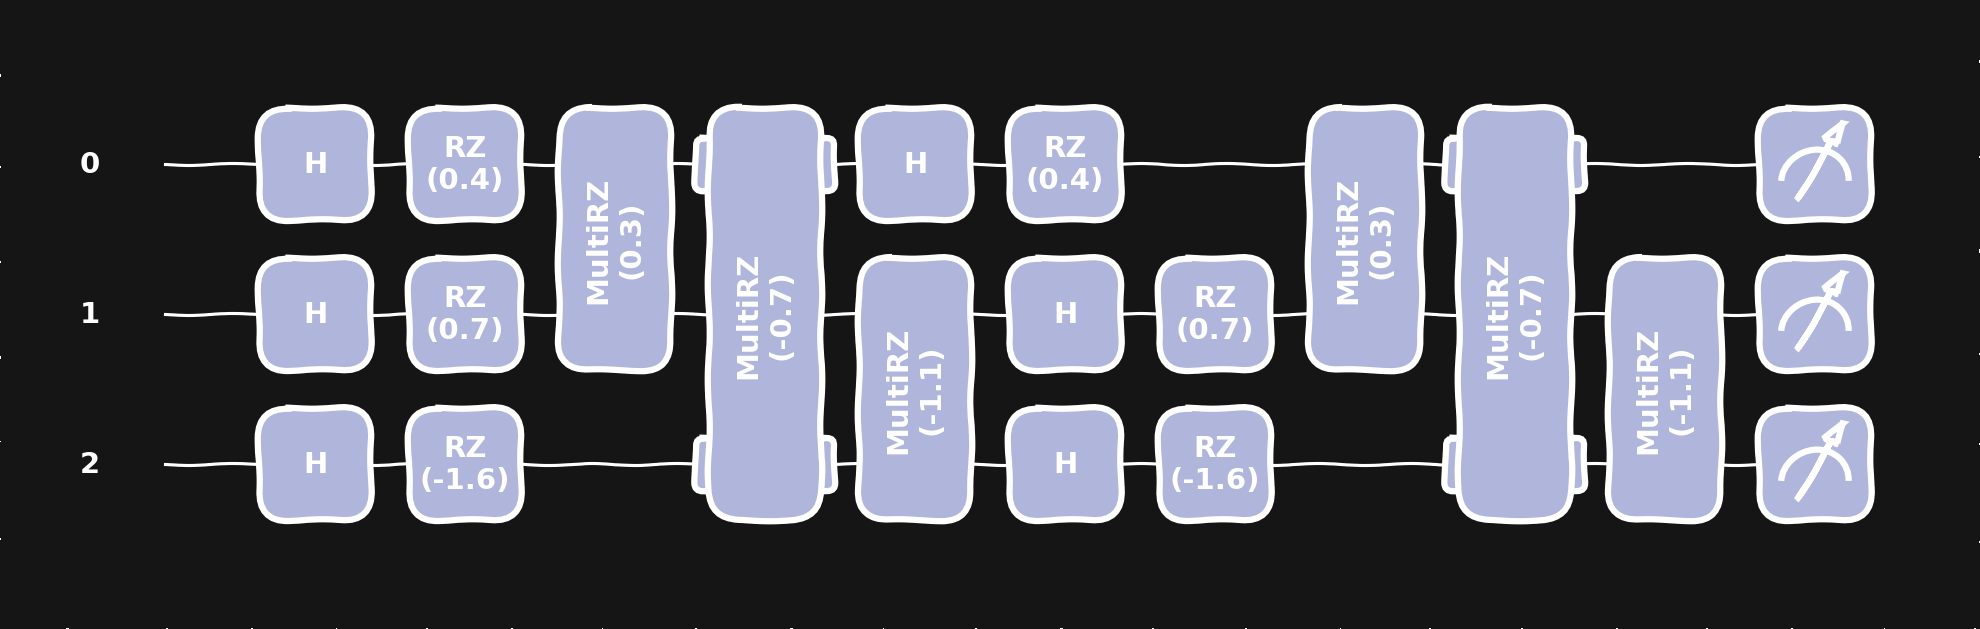

In [5]:
@qml.qnode(dev)
def iqp(x: NDArray) -> qml.QNode:
    qml.IQPEmbedding(x, n_repeats=2, wires=range(num_features))
    return qml.state()

fig, ax = qml.draw_mpl(
    iqp, style="sketch_dark", show_all_wires=True, level=None, decimals=1
)(X_train[0])

## Quantum Kernels

Let's use the <code>FidelityQuantumKernel</code>-class to obtain the kernel matrix:

In [6]:
quantum_kernel = FidelityQuantumKernel(data_embedding="IQP", jit=True, reps=2)

quantum_kernel.initialize_params(feature_dimension=X_train.shape[1])
kernel_train = quantum_kernel.evaluate(X_train, X_train)
kernel_test = quantum_kernel.evaluate(X_test, X_train)

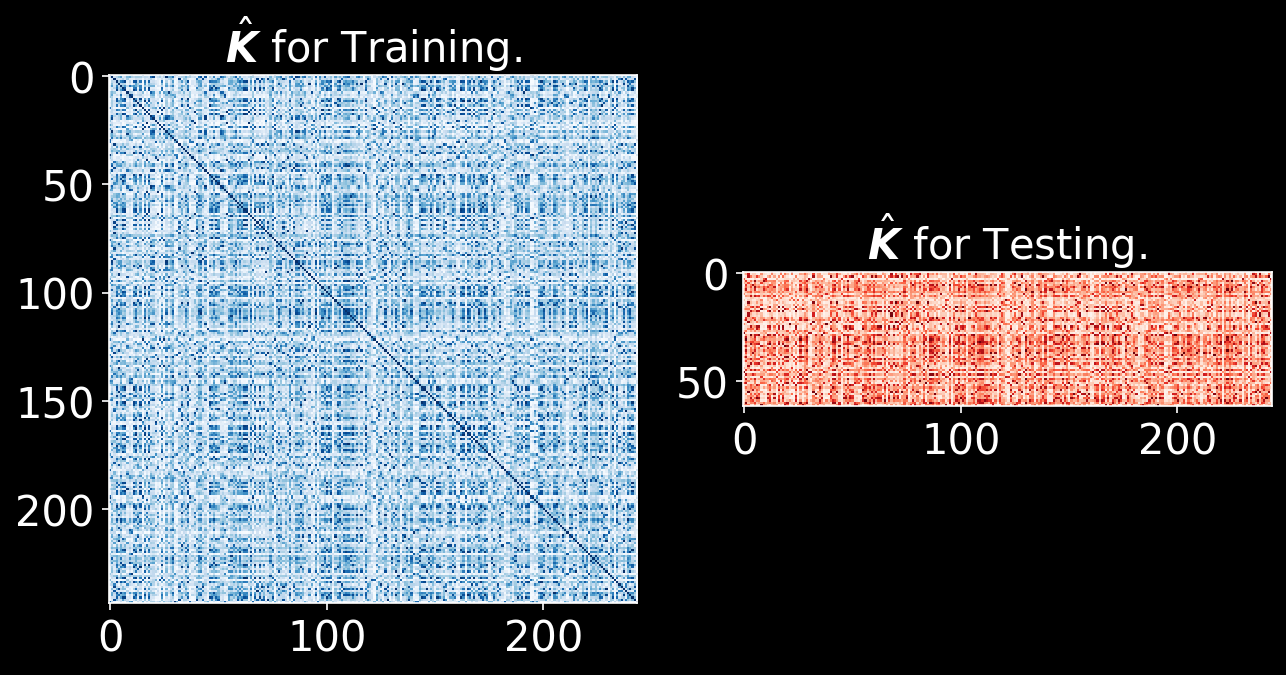

In [7]:
plot_kernel_heatmap(kernel_train, kernel_test)

In [8]:
precomputed_kernel_svc = SVC(kernel="precomputed", random_state=random_state)
precomputed_kernel_svc.fit(kernel_train, y_train)
precomputed_quantum_kernel_score = precomputed_kernel_svc.score(kernel_test, y_test)
print(f"Precomputed kernel classification score: {precomputed_quantum_kernel_score}")

Precomputed kernel classification score: 0.6935483870967742


In [9]:
y_pred = precomputed_kernel_svc.predict(kernel_test)
acc = metrics.balanced_accuracy_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("Prediction scores: \n")
print(f"Accuracy:\t{acc:.2f}")
print(f" ROC_AUC:\t{roc_auc:.2f}")

Prediction scores: 

Accuracy:	0.50
 ROC_AUC:	0.50
